# Likelihood Analysis with Python

The python likelihood tools are a very powerful set of analysis tools that expand upon the command line tools provided with the Fermi Science Tools package. Not only can you perform all of the same likelihood analysis with the python tools that you can with the standard command line tools but you can directly access all of the model parameters.  You can more easily script a standard analysis like light curve generation.  There are also a few things built into the python tools that are not available from the command line like the calculation of upper limits.

There are many [user contributed packages](https://fermi.gsfc.nasa.gov/ssc/data/analysis/user/) built upon the python backbone of the Science Tools and we are going to highlight and use a few of them in this tutorial.

This sample analysis will look at 2 years of data for the object 3C 279, which is a relatively birght example of a type of Active Galactic Nucleus (AGN) known as a blazar. At certain points we will refer to this article as well as the [Cicerone](https://fermi.gsfc.nasa.gov/ssc/data/analysis/documentation/Cicerone/). This tutorial is based on the "[Binned Likelihood Tutorial](https://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/binned_likelihood_tutorial.html)" Analysis Thread, which is hosted on the Fermi Science Support Center website. 

This tutorial assumes you have the most recent [ScienceTools](https://fermi.gsfc.nasa.gov/ssc/data/analysis/software/) installed. We will also make significant use of python, so you might want to familiarize yourself with python (there's a beginner's guide at http://wiki.python.org/moin/BeginnersGuide. This tutorial also assumes that you've gone through the non-python based [unbinned likelihood](https://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/likelihood_tutorial.html) thread. Running through this notebook should take several hours to complete (depending on your computer's speed) if you do everything but there are some steps you can skip along the way which would shorten that.

> **Note:** This tutorial is generated from a [jupyter notebook](https://github.com/kialio/FSSC-Docs/blob/master/Threads/Python/python_tutorial.ipynb) which you can download and run yourself (the prefereed method). You can also run individual commands listed on this page.  If you do that, be aware that some commands must be executed in an ipython/jupyter environment.

## Get the Data

For this thread the original data were extracted from the [LAT data server](https://fermi.gsfc.nasa.gov/cgi-bin/ssc/LAT/LATDataQuery.cgi) with the following selections (these selections are similar to those in the paper):

* Search Center (RA,Dec) = (193.98, -5.82)
* Radius = 15 degrees
* Start Time (MET) = 239557417 seconds (2008-08-04 T15:43:37)
* Stop Time (MET) = 302572802 seconds (2010-08-04 T00:00:00)
* Minimum Energy = 100 MeV
* Maximum Energy = 500000 MeV

We've provided direct links to the event files as well as the spacecraft data file if you don't want to take the time to use the download server. For more information on how to download LAT data please see the [Extract LAT Data](https://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/explore_latdata.html) tutorial.

* [L181126210218F4F0ED2738_PH00.fits](https://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/data/BinnedLikelihood/L181126210218F4F0ED2738_PH00.fits)
* [L181126210218F4F0ED2738_PH01.fits](https://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/data/BinnedLikelihood/L181126210218F4F0ED2738_PH01.fits)
* [L181126210218F4F0ED2738_PH02.fits](https://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/data/BinnedLikelihood/L181126210218F4F0ED2738_PH02.fits)
* [L181126210218F4F0ED2738_PH03.fits](https://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/data/BinnedLikelihood/L181126210218F4F0ED2738_PH03.fits)
* [L181126210218F4F0ED2738_PH04.fits](https://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/data/BinnedLikelihood/L181126210218F4F0ED2738_PH04.fits)
* [L181126210218F4F0ED2738_PH05.fits](https://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/data/BinnedLikelihood/L181126210218F4F0ED2738_PH05.fits)
* [L181126210218F4F0ED2738_PH06.fits](https://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/data/BinnedLikelihood/L181126210218F4F0ED2738_PH06.fits)
* [L181126210218F4F0ED2738_SC00.fits](https://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/data/BinnedLikelihood/L181126210218F4F0ED2738_SC00.fits)

Make a working directory and then download all of the files into that directory.

In [1]:
!mkdir working



In [5]:
import urllib.request



In [6]:
url_base = "/Users/87steven/Documents/ASIAA/Blazar SED code and data/Fermi all-sky survey data/J0001-1551/"

datafiles = ["L221124084908FC8CDD7386_PH00.fits", 
             "L221124084908FC8CDD7386_PH01.fits"]



In [ ]:
for datafile in datafiles:
    urllib.request.urlretrieve(url_base + datafile, "working/" + datafile)
    


In [8]:
ls working/



ls: working/: No such file or directory


Now, you'll first need to make a file list with the names of your input event files:

In [6]:
ls -1 working/*PH*.fits > binned_events.txt



We can rename the spacecraft file to make it easier to work with:

In [7]:
mv working/L181126210218F4F0ED2738_SC00.fits working/3C279_SC.fits



In the following analysis we've assumed that you've named your list of data files binned_events.list and the spacecraft file 3C279_SC.fits.

In [8]:
#Let's get a timestamp, so we can see how long this takes to run on your machine.
!date



2022年12月 3日 週六 15時36分35秒 CST


## Perform Event Selections

The gt_apps module provides methods to call the various FermiTools from within python. 

In [9]:
import gt_apps as my_apps



The python object for gtselect is called filter and we first need to set all of its options. It might not seem that convenient to do it this way (as opposed to entering the options via the command line) but it's really nice once you start building up scripts and reading back options and such. For example, generating a light curve entails running the likelihood analysis for each datapoint. It'll be much easier to do all of that within python and change the tmin and tmax in an iterative fashion. Note that these python objects are just wrappers for the standalone tools so if you want any information on their options, see the corresponding [documentation](/ssc/data/analysis/scitools/references.html) for the standalone tool.

In [25]:
RA = 329.716958
DEC = -30.225578
emin = 100
emax = 500000
energy_bin_num = 37
z_max = 90


In [10]:
### gt filters (done)

my_apps.filter['evclass'] = 128
my_apps.filter['evtype'] = 3
my_apps.filter['ra'] = 'INDEF'
my_apps.filter['dec'] = 'INDEF'
my_apps.filter['rad'] = 'INDEF'
my_apps.filter['emin'] = emin
my_apps.filter['emax'] = emax
my_apps.filter['zmax'] = z_max
my_apps.filter['tmin'] = 'INDEF'
my_apps.filter['tmax'] = 'INDEF'
my_apps.filter['infile'] = '@binned_events.txt'
my_apps.filter['outfile'] = 'working/3C279_binned_filtered.fits'



Now, run gtselect:

In [2]:
my_apps.filter.run()



time -p gtselect infile=/Users/87steven/Documents/ASIAA/Blazar SED code and data/Fermi_all_sky_survey_data/J0001-1551/events.txt outfile=/Users/87steven/Documents/ASIAA/Blazar SED code and data/Fermi_all_sky_survey_data/J0001-1551/filtered.fits ra=0.272042 dec=-15.851939 rad=1.0 tmin="INDEF" tmax="INDEF" emin=100.0 emax=300000.0 zmin=0.0 zmax=90.0 evclass="INDEF" evtype="INDEF" convtype=-1 phasemin=0.0 phasemax=1.0 evtable="EVENTS" chatter=2 clobber=yes debug=no gui=no mode="ql"
Parameter "infile" duplicated on command line.
Parameter "infile" duplicated on command line.
Caught N5hoops12ApeExceptionE at the top level: Cannot open parameter file for gtselect; Ape exception code 19 (at /Users/runner/miniforge3/conda-bld/fermitools_1655479516925/work/src/hoops/src/hoops_ape.cxx: 435)


RuntimeError: gtselect execution failed

Next, you need to run gtmktime. This is accessed within python via the maketime object:

In [12]:
### gt maketime (done)

my_apps.maketime['scfile'] = 'working/3C279_SC.fits'
my_apps.maketime['filter'] = '(DATA_QUAL>0) && (LAT_CONFIG==1)'
my_apps.maketime['roicut'] = 'no'
my_apps.maketime['evfile'] = 'working/3C279_binned_filtered.fits'
my_apps.maketime['outfile'] = 'working/3C279_binned_gti.fits'
my_apps.maketime.run()



time -p gtmktime scfile=working/3C279_SC.fits sctable="SC_DATA" filter="(DATA_QUAL>0)&&(LAT_CONFIG==1)" roicut=no evfile=working/3C279_binned_filtered.fits evtable="EVENTS" outfile="working/3C279_binned_gti.fits" apply_filter=yes overwrite=no header_obstimes=yes tstart=0.0 tstop=0.0 gtifile="default" chatter=2 clobber=yes debug=no gui=no mode="ql"
real 21.44
user 20.43
sys 0.76


We're using the most conservative and most commonly used cuts described in detail in the [Cicerone](http://fermi.gsfc.nasa.gov/ssc/data/analysis/documentation/Cicerone/Cicerone_Likelihood/Exposure.html).

## Create a 3-D (binned) counts map

For binned likelihood analysis, the data input is a three-dimensional counts map with an energy axis, called a counts cube. The gtbin tool performs this task as well, by using the CCUBE option.data_path = '/Users/87steven/Documents/ASIAA/Blazar SED code and data/Fermi_all_sky_survey_data/J0001-1551'

import gt_apps as my_apps
from gt_apps import counts_map
import shutil
from os import listdir
from GtApp import GtApp
import urllib.request

In [26]:

import gt_apps as my_apps
from gt_apps import counts_map
import shutil
from os import listdir
from GtApp import GtApp
import urllib.request

RA = 329.716958
DEC = -30.225578
emin = 100
emax = 500000
energy_bin_num = 37
z_max = 90



In [27]:
### start from here

data_path = '/Users/87steven/Documents/ASIAA/Blazar SED code and data/Fermi_all_sky_survey_data/J2158-3013'

scfile = " '" + data_path + "/SC00.fits' "
evfile = " '" + data_path + "/binned_gti.fits' "
outfile = " '" + data_path + "/binned_ccube.fits' "

### gt count maps
my_apps.counts_map['algorithm'] = 'CCUBE'
my_apps.counts_map['evfile'] = evfile
my_apps.counts_map['scfile'] = 'none'
my_apps.counts_map['outfile'] = outfile
my_apps.counts_map['nxpix'] = 100
my_apps.counts_map['nypix'] = 100
my_apps.counts_map['binsz'] = 0.2
my_apps.counts_map['coordsys'] = 'CEL'
my_apps.counts_map['xref'] = RA   # RA
my_apps.counts_map['yref'] = DEC   # DEC
my_apps.counts_map['axisrot'] = 0
my_apps.counts_map['proj'] = 'AIT'
my_apps.counts_map['ebinalg'] = 'LOG'
my_apps.counts_map['emin'] = emin
my_apps.counts_map['emax'] = emax
my_apps.counts_map['enumbins'] = energy_bin_num

my_apps.counts_map.run()



time -p gtbin evfile= '/Users/87steven/Documents/ASIAA/Blazar SED code and data/Fermi_all_sky_survey_data/J2158-3013/binned_gti.fits'  scfile=none outfile= '/Users/87steven/Documents/ASIAA/Blazar SED code and data/Fermi_all_sky_survey_data/J2158-3013/binned_ccube.fits'  algorithm="CCUBE" ebinalg="LOG" emin=100.0 emax=500000.0 enumbins=37 denergy=0.0 ebinfile=NONE tbinalg="LIN" tstart=0.0 tstop=0.0 dtime=0.0 tbinfile=NONE snratio=0.0 lcemin=0.0 lcemax=0.0 nxpix=100 nypix=100 binsz=0.2 coordsys="CEL" xref=329.716958 yref=-30.225578 axisrot=0.0 rafield="RA" decfield="DEC" proj="AIT" hpx_ordering_scheme="RING" hpx_order=3 hpx_ebin=yes hpx_region="" evtable="EVENTS" sctable="SC_DATA" efield="ENERGY" tfield="TIME" chatter=2 clobber=yes debug=no gui=no mode="ql"
This is gtbin version HEAD
gtbin: WARNING: No spacecraft file: EXPOSURE keyword will be set equal to ontime.
real 0.22
user 0.14
sys 0.02


## Livetime Cubes and Exposure Maps

The next two steps pre-compute the livetime over the whole sky and the exposure map over your are of intere, respectively. Doing this in advance of running the likelihood tool will save a significant amount of time when running the gtlike task itself. This can be usefull if you wish to re-do the likelihood analysis multiple times (after, say, adjusting the model inputs or trying out different fitting algorithms). So, let's go ahead and do these "extra" steps.

### Livetime Cube

We can pre-compute the livetime as a function of sky position and off-axis angle, which will speed up the likelihood analysis. This step will take approximately 30 minutes to complete, so this may be a good time to respond to that email you've been thinking about.

In [28]:
evfile = data_path + "/binned_gti.fits"
scfile = " '" + data_path + "/SC00.fits' "
outfile = " '" + data_path + "/ltcube.fits' "

### gt exp Cube
my_apps.expCube['evfile'] = evfile
my_apps.expCube['scfile'] = scfile
my_apps.expCube['outfile'] = outfile
my_apps.expCube['zmax'] = 90
my_apps.expCube['dcostheta'] = 0.025
my_apps.expCube['binsz'] = 1
my_apps.expCube.run()



time -p gtltcube evfile="/Users/87steven/Documents/ASIAA/Blazar SED code and data/Fermi_all_sky_survey_data/J2158-3013/binned_gti.fits" evtable="EVENTS" scfile= '/Users/87steven/Documents/ASIAA/Blazar SED code and data/Fermi_all_sky_survey_data/J2158-3013/SC00.fits'  sctable="SC_DATA" outfile= '/Users/87steven/Documents/ASIAA/Blazar SED code and data/Fermi_all_sky_survey_data/J2158-3013/ltcube.fits'  dcostheta=0.025 binsz=1.0 phibins=0 tmin=0.0 tmax=0.0 file_version="1" zmin=0.0 zmax=90.0 chatter=2 clobber=yes debug=no gui=no mode="ql"
Working on file /Users/87steven/Documents/ASIAA/Blazar SED code and data/Fermi_all_sky_survey_data/J2158-3013/SC00.fits
.....................!
real 266.43
user 265.32
sys 0.74


### Exposure Map

This next step will apply the livetime calculated in the previous step to your region of interest. This tool generates a binned exposure map, an accounting of the exposure at each position in the sky, that are a required input to the likelihood process. 

The LAT has a very large Point Spread Function (PSF), especially at low energies. In order to account for contributions from sources outside our ROI we need to make the exposure map cover a larger area on the sky, equal to the ROI plus 10 degrees.

In [29]:
### create model file
expCube2 = GtApp('gtexpcube2', 'Likelihood')


In [30]:
infile = " '" + data_path + "/ltcube.fits' "
cmap = 'none'
outfile = " '" + data_path + "/binned_exp_map.fits' "

expCube2['infile'] = infile
expCube2['cmap'] = cmap
expCube2['outfile'] = outfile
expCube2['irfs'] = 'P8R3_SOURCE_V3'
expCube2['evtype'] = '3'
expCube2['nxpix'] = 1800
expCube2['nypix'] = 900
expCube2['binsz'] = 0.2
expCube2['coordsys'] = 'CEL'
expCube2['xref'] = RA
expCube2['yref'] = DEC
expCube2['axisrot'] = 0
expCube2['proj'] = 'AIT'
expCube2['ebinalg'] = 'LOG'
expCube2['emin'] = emin
expCube2['emax'] = emax
expCube2['enumbins'] = energy_bin_num
expCube2.run()



time -p gtexpcube2 infile= '/Users/87steven/Documents/ASIAA/Blazar SED code and data/Fermi_all_sky_survey_data/J2158-3013/ltcube.fits'  cmap=none outfile= '/Users/87steven/Documents/ASIAA/Blazar SED code and data/Fermi_all_sky_survey_data/J2158-3013/binned_exp_map.fits'  irfs="P8R3_SOURCE_V3" evtype=3 edisp_bins=0 nxpix=1800 nypix=900 binsz=0.2 coordsys="CEL" xref=329.716958 yref=-30.225578 axisrot=0.0 proj="AIT" ebinalg="LOG" emin=100.0 emax=500000.0 enumbins=37 ebinfile="NONE" hpx_ordering_scheme="RING" hpx_order=6 bincalc="EDGE" ignorephi=no thmax=180.0 thmin=0.0 table="EXPOSURE" chatter=2 clobber=yes debug=no mode="ql"
Computing binned exposure map....................!
Using evtype=3 (i.e., FRONT/BACK irfs)
real 104.04
user 102.62
sys 1.23


## Generate XML Model File

We need to create an XML file with all of the sources of interest within the Region of Interest (ROI) of 3C 279 so we can correctly model the background. For more information on the format of the model file and how to create one, see the [likelihood analysis](https://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/likelihood_tutorial.html#createSourceModel) tutorial. We'll use the user contributed tool `make4FGLxml.py` to create a model file based on the LAT 4-year LAT catalog. You'll need to download the FITS version of this file at [http://fermi.gsfc.nasa.gov/ssc/data/access/lat/4yr_catalog/](http://fermi.gsfc.nasa.gov/ssc/data/access/lat/4yr_catalog/) and get the [make4FGLxml.py](https://fermi.gsfc.nasa.gov/ssc/data/analysis/user/python3/make4FGLxml.py) tool from the [user contributed software](http://fermi.gsfc.nasa.gov/ssc/data/analysis/user/) page and put them both in your working directory. Also make sure you have the most recent galactic diffuse and isotropic model files which can be found at [http://fermi.gsfc.nasa.gov/ssc/data/access/lat/BackgroundModels.html](http://fermi.gsfc.nasa.gov/ssc/data/access/lat/BackgroundModels.html). In the following we assume that you have the galactic diffuse and isotropic files in your FermiTools install and we just make local symbolic links.

In [31]:
### make4FGLxml.py
urllib.request.urlretrieve('https://fermi.gsfc.nasa.gov/ssc/data/analysis/user/make4FGLxml.py', 'make4FGLxml.py')

### gll_psc_v26.xml
urllib.request.urlretrieve('https://fermi.gsfc.nasa.gov/ssc/data/access/lat/10yr_catalog/gll_psc_v26.xml', data_path+'/gll_psc_v26.xml')

### iso_P8R3_SOURCE_V3_v1.txt
!ln -s $FERMI_DIR/refdata/fermi/galdiffuse/iso_P8R3_SOURCE_V3_v1.txt '/Users/87steven/Documents/ASIAA/Blazar SED code and data/Fermi_all_sky_survey_data/J2158-3013/iso_P8R3_SOURCE_V3_v1.txt'

### gll_iem_v07.fits
!ln -s $FERMI_DIR/refdata/fermi/galdiffuse/gll_iem_v07.fits '/Users/87steven/Documents/ASIAA/Blazar SED code and data/Fermi_all_sky_survey_data/J2158-3013/gll_iem_v07.fits'



In [32]:
!ls '/Users/87steven/Documents/ASIAA/Blazar SED code and data/Fermi_all_sky_survey_data/J0001-1551/'


PH00.fits                 binned_filtered.fits      gll_psc_v26.xml
PH01.fits                 binned_gti.fits           inned_srcmaps.fits
SC00.fits                 binned_srcmaps.fits       iso_P8R3_SOURCE_V3_v1.txt
binned_ccube.fits         events.txt                ltcube.fits
binned_exp_map.fits       gll_iem_v07.fits          model.xml


Now that we have all of the files we need, you can generate your model file:

In [33]:
from make4FGLxml import *

mymodel = srcList(data_path+'/gll_psc_v26.xml', data_path+'/binned_gti.fits', data_path+'/model.xml')

mymodel.makeModel(data_path+'/gll_iem_v07.fits', 'gll_iem_v07.fits',  # .fits
                  data_path+'/iso_P8R3_SOURCE_V3_v1.txt', 'iso_P8R3_SOURCE_V3_v1')



Creating file and adding sources from 4FGL
Added 40 point sources and 0 extended sources


You can open the model file with your favorite text editor to have a look at it. In the 4FGL catalog, 3C 279 is referred to as "4FGL J1256.1-0547". The model for this source is reproduced below. Note the parameters that say "free="1"" - the "1" indicates that these parameters will be left free during the likelihood analysis, which will also be true for several of the other sources in our ROI.

### Source Map

The [gtsrcmaps](https://raw.githubusercontent.com/fermi-lat/fermitools-fhelp/master/gtsrcmaps.txt) tool creates model counts maps for use with the binned likelihood analysis. To do this, it takes each source spectrum in the XML model, multiplies it by the exposure at the source position, and convolves that exposure with the effective PSF.

In [34]:

expcube = " '/Users/87steven/Documents/ASIAA/Blazar SED code and data/Fermi_all_sky_survey_data/J2158-3013/ltcube.fits' "
cmap = " '/Users/87steven/Documents/ASIAA/Blazar SED code and data/Fermi_all_sky_survey_data/J2158-3013/binned_ccube.fits' "
srcmdl = " '/Users/87steven/Documents/ASIAA/Blazar SED code and data/Fermi_all_sky_survey_data/J2158-3013/model.xml' "
bexpmap = " '/Users/87steven/Documents/ASIAA/Blazar SED code and data/Fermi_all_sky_survey_data/J2158-3013/binned_exp_map.fits' "
outfile = " '/Users/87steven/Documents/ASIAA/Blazar SED code and data/Fermi_all_sky_survey_data/J2158-3013/binned_srcmaps.fits' "

my_apps.srcMaps['expcube'] = expcube
my_apps.srcMaps['cmap'] = cmap
my_apps.srcMaps['srcmdl'] = srcmdl
my_apps.srcMaps['bexpmap'] = bexpmap
my_apps.srcMaps['irfs'] = 'CALDB'
my_apps.srcMaps['outfile'] = outfile

my_apps.srcMaps.run()



time -p gtsrcmaps scfile= sctable="SC_DATA" expcube= '/Users/87steven/Documents/ASIAA/Blazar SED code and data/Fermi_all_sky_survey_data/J2158-3013/ltcube.fits'  cmap= '/Users/87steven/Documents/ASIAA/Blazar SED code and data/Fermi_all_sky_survey_data/J2158-3013/binned_ccube.fits'  srcmdl= '/Users/87steven/Documents/ASIAA/Blazar SED code and data/Fermi_all_sky_survey_data/J2158-3013/model.xml'  bexpmap= '/Users/87steven/Documents/ASIAA/Blazar SED code and data/Fermi_all_sky_survey_data/J2158-3013/binned_exp_map.fits'  wmap=none outfile= '/Users/87steven/Documents/ASIAA/Blazar SED code and data/Fermi_all_sky_survey_data/J2158-3013/binned_srcmaps.fits'  irfs="CALDB" evtype="INDEF" convol=yes resample=yes rfactor=2 minbinsz=0.1 ptsrc=yes psfcorr=yes emapbnds=yes edisp_bins=0 copyall=no chatter=2 clobber=yes debug=no gui=no mode="ql"
Function::parameter(std::string &): 
A Parameter named Expfactor is not a Parameter of Function 

Caught N10optimizers17ParameterNotFoundE at the top level: F

RuntimeError: gtsrcmaps execution failed

## Compute the diffuse source responses.

The diffuse source responses tell the likelihood fitter what the expected contribution would be for each diffuse source, given the livetime associated with each event. The source model XML file must contain all of the diffuse sources to be fit. The [gtdiffrsp](https://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/help/gtdiffrsp.txt) tool will add one column to the event data file for each diffuse source. The diffuse response depends on the instrument response function (IRF), which must be in agreement with the selection of events, i.e. the event class and event type we are using in our analysis. Since we are using SOURCE class, CALDB should use the P8R3_SOURCE_V3 IRF for this tool.

If the diffuse responses are not precomputed using [gtdiffrsp](https://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/help/gtdiffrsp.txt), then the [gtlike](https://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/help/gtlike.txt) tool will compute them at runtime (during the next step). However, as this step is very computationally intensive (often taking ~hours to complete), and it is very likely you will need to run [gtlike](https://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/help/gtlike.txt) more than once, it is probably wise to precompute these quantities.


In [77]:
evfile = " '" + data_path + "/binned_gti.fits' "
scfile = " '" + data_path + "/SC00.fits' "
srcmdl = " '" + data_path + "/model.xml' "

my_apps.diffResps['evfile'] = evfile 
my_apps.diffResps['scfile'] = scfile 
my_apps.diffResps['srcmdl'] = srcmdl 
my_apps.diffResps['irfs'] = 'CALDB'
my_apps.diffResps.run()



time -p gtdiffrsp evfile= '/Users/87steven/Documents/ASIAA/Blazar SED code and data/Fermi_all_sky_survey_data/J0001-1551/binned_gti.fits'  evtable="EVENTS" scfile= '/Users/87steven/Documents/ASIAA/Blazar SED code and data/Fermi_all_sky_survey_data/J0001-1551/SC00.fits'  sctable="SC_DATA" srcmdl= '/Users/87steven/Documents/ASIAA/Blazar SED code and data/Fermi_all_sky_survey_data/J0001-1551/model.xml'  irfs="CALDB" evclsmin=0 evclass="INDEF" evtype="INDEF" convert=no chatter=2 clobber=no debug=no gui=no mode="ql"
adding source gll_iem_v07.fits
adding source iso_P8R3_SOURCE_V3_v1
Working on...
/Users/87steven/Documents/ASIAA/Blazar SED code and data/Fermi_all_sky_survey_data/J0001-1551/binned_gti.fits.....................!
real 8.41
user 7.89
sys 0.46


## Run the Likelihood Analysis

It's time to actually run the likelihood analysis now. First, you need to import the pyLikelihood module and then the UnbinnedAnalysis functions (there's also a binned analysis module that you can import to do [binned likelihood analysis](https://fermi.gsfc.nasa.gov//ssc/data/analysis/scitools/binned_likelihood_tutorial.html) which behaves almost exactly the same as the unbinned analysis module).  For more details on the pyLikelihood module, check out the [pyLikelihood Usage Notes](https://fermi.gsfc.nasa.gov//ssc/data/analysis/scitools/python_usage_notes.html).

In [78]:
data_path

'/Users/87steven/Documents/ASIAA/Blazar SED code and data/Fermi_all_sky_survey_data/J0001-1551'

In [79]:
!ls '/Users/87steven/Documents/ASIAA/Blazar SED code and data/Fermi_all_sky_survey_data/J0001-1551/'



PH00.fits                 binned_gti.fits           iso_P8R3_SOURCE_V3_v1.txt
PH01.fits                 binned_srcmaps.fits       ltcube.fits
SC00.fits                 events.txt                mktime.fits
binned_ccube.fits         filtered.fits             model.xml
binned_exp_map.fits       gll_iem_v07.fits
binned_filtered.fits      gll_psc_v26.xml


In [134]:
import pyLikelihood
from BinnedAnalysis import *

srcmap = data_path + "/binned_srcmaps.fits"
bexpmap = data_path + "/binned_exp_map.fits"
expcube = data_path + "/ltcube.fits"

obs = BinnedObs(srcMaps = srcmap, binnedExpMap = bexpmap, expCube = expcube, irfs = 'CALDB')

like = BinnedAnalysis(obs, data_path+'/model.xml', optimizer = 'NewMinuit')


By now, you'll have two objects, 'obs', an UnbinnedObs object and like, an UnbinnedAnalysis object. You can view these objects attributes and set them from the command line in various ways. For example:

In [135]:
print(obs)



Source maps: /Users/87steven/Documents/ASIAA/Blazar SED code and data/Fermi_all_sky_survey_data/J0001-1551/binned_srcmaps.fits
Exposure cube: /Users/87steven/Documents/ASIAA/Blazar SED code and data/Fermi_all_sky_survey_data/J0001-1551/ltcube.fits
Exposure map: /Users/87steven/Documents/ASIAA/Blazar SED code and data/Fermi_all_sky_survey_data/J0001-1551/binned_exp_map.fits
IRFs: CALDB


In [136]:
print(like)



Source maps: /Users/87steven/Documents/ASIAA/Blazar SED code and data/Fermi_all_sky_survey_data/J0001-1551/binned_srcmaps.fits
Exposure cube: /Users/87steven/Documents/ASIAA/Blazar SED code and data/Fermi_all_sky_survey_data/J0001-1551/ltcube.fits
Exposure map: /Users/87steven/Documents/ASIAA/Blazar SED code and data/Fermi_all_sky_survey_data/J0001-1551/binned_exp_map.fits
IRFs: CALDB
Source model file: /Users/87steven/Documents/ASIAA/Blazar SED code and data/Fermi_all_sky_survey_data/J0001-1551/model.xml
Optimizer: NewMinuit


There are a lot of attributes and here you start to see the power of using pyLikelihood since you'll be able (once the fit is done) to access any of these attributes directly within python and use them in your own scripts.

Now, we're ready to do the actual fit. This next step will take approximately 10 minutes to complete.  We're doing something a bit fancy here.  We're getting the minimizating object (and calling it `likeobj`) from the logLike object so that we can access it later.  We pass this object to the fit routine so that it knows which fitting object to use.  We're also telling the code to calculate the
covariance matrix so we can get at the errors.

In [138]:
### perform model fit
likeobj = pyLikelihood.NewMinuit(like.logLike)

like.fit(verbosity = 0, covar = True, optObject = likeobj)


3728.8404031157856

The number that is printed out here is the -log(Likelihood) of the total fit to the data. You can print the results of the fit by accessing like.model. You can also access the fit for a particular source by doing the following (the source name must match that in the XML model file).

In [197]:
### print out fitted parameters of each FGL source

#like.model

# J0001-1551

### get source name


In [161]:
### can specify source name to print out fitted parameters
like.model['4FGL J0025.2-2231']


4FGL J0025.2-2231
   Spectrum: PowerLaw
42     Prefactor:  3.533e+00  0.000e+00  0.000e+00  1.000e+02 ( 4.462e-14) fixed
43         Index:  2.503e+00  0.000e+00  0.000e+00  5.000e+00 (-1.000e+00) fixed
44         Scale:  1.015e+03  0.000e+00  6.979e+02  1.537e+03 ( 1.000e+00) fixed

The Test Statistic (TS) value is a useful quantity to record when evaluating likelihood results. A TS > 25 is generally considered a strong detection with a high likelihood of being real. 

In [202]:
name_list = like.sourceNames()

for i in name_list:
    Ts = like.Ts(i)
    print(i, '=', Ts)


4FGL J0001.2-0747 = -169.34919491821256
4FGL J0002.3-0815 = -20.103513068207576
4FGL J0003.3-1928 = -70.60566628098695
4FGL J0003.9-1149 = -34.81416511593034
4FGL J0006.3-0620 = -23.785108329887407
4FGL J0008.4-2339 = -17.098538280097273
4FGL J0009.7-1418 = -82.21844022577079
4FGL J0010.2-2431 = -20.973693007696966
4FGL J0010.8-2154 = -47.86142491056489
4FGL J0013.9-1854 = -56.64968181241329
4FGL J0017.0-0649 = -102.72347669304054
4FGL J0021.6-0855 = -48.949575731332516
4FGL J0022.1-1854 = -97.89164144702318
4FGL J0025.2-2231 = -55.65129000097386
4FGL J0026.1-0732 = -22.639260720387938
4FGL J0030.2-1647 = -37.492460675109214
4FGL J0031.0-2327 = -14.085339765443678
4FGL J0033.3-2040 = -9.291778150674872
4FGL J0033.5-1921 = -258.1462365361276
4FGL J0035.2-1739 = -10.140061586886986
4FGL J0041.7-1607 = -5.8828212034277385
4FGL J2321.5-1619 = -35.60247973584228
4FGL J2325.2-2010 = -26.82160528935401
4FGL J2329.7-2118 = -143.17279552660602
4FGL J2330.3-2332 = -38.281861699653746
4FGL J2331.

You can plot the results of the fit by executing the plot command. The results are shown below:


Data  187.0
srcName  85.26226248654845
srcName  10.129431323134307
srcName  37.90206768137219
srcName  18.21359105763847
srcName  11.945040433312101
srcName  8.584514411300178
srcName  55.264646127672776
srcName  10.533708388392244
srcName  24.314245102863193
srcName  29.73571323096173
srcName  51.57098266876533
srcName  24.62090968234608
srcName  49.580019439530815
srcName  27.98878671962482
srcName  11.3454150859889
srcName  18.900167783579477
srcName  7.044569955193932
srcName  4.660340577904729
srcName  129.43067352784826
srcName  5.091822283239148
srcName  2.949806536618775
srcName  17.85632693135622
srcName  13.450276224400232
srcName  71.91522089066945
srcName  19.185587499825505
srcName  177.51503923217226
srcName  39.821555365970305
srcName  41.5358497012781
srcName  67.97389844507106
srcName  10.797515289061932
srcName  1045.5771556978211
srcName  464.475966568773
srcName  13.455019283259642
srcName  14.69934322520254
srcName  26.11108934228864
srcName  20.37645784989803
srcN

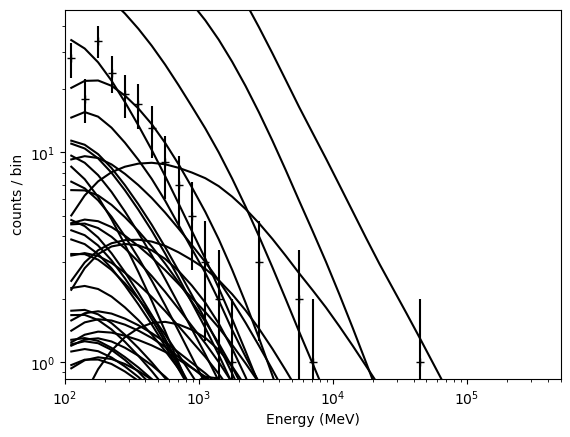

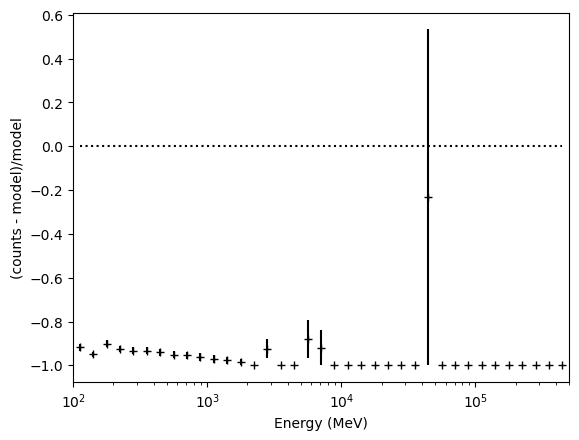

In [125]:
%matplotlib inline
like.plot()



The output of the plot function of the like BinnedAnalysis object shows:

* Top: the contribution of each of the objects in the model to the total model, and plots the data points on top.
* Bottom: the residuals of the likelihood fit to the data.Notice that the fit is poor in the second to last bin.

Now, check for convergence.

In [37]:
#print(likeobj.getRetCode())

If you get anything other than '0' here, than NewMinuit didn't converge. There are several reasons that we might not get convergance:

* The culprit is usually a parameter (or parameters) in the model that reach the limits set in the XML file. If this happens the minimizer cannot reach the formal minimum, and hence cannot calculate the curvature.
* Often the problem is with spectral shape parameters (PL index etc..), so simply freezing the shape of all spectral parameters to their values from the full time period (and certainly for weaker background sources) when fitting a shorter time period may solve the problem. Remember that the 3FGL catalog used a full 4 years of data and we're using a much shorter time period here
* Weak background sources are more likely to cause problems, so you could consider just freezing them completely (or removing them from the model). For example a background source from the catalog that is detected at TS~=25 in 2 years could cause convergence problems in a 1-month light curve, where it will often not be detectable at all.
* If there are no parameters at their limits, then increasing the overall convergence tolerance may help - try using a value of 1E-8 for the absolute tolerance.
* If that doesn't help then try to systematically simplify the model. Progressively freeze all sources, starting with those at the edge of the ROI in and moving in until you get a model simple enough for the minimizer to work reliably. For example if you are using a 10 degree ROI, you could start by freezing all background sources further than 7 degrees from the source of interest, and move to 5 degrees if that doesn't solve the problem.

In [35]:
!date

Wed Dec 16 02:19:54 EST 2020
